In [15]:
# Based on docs:
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html

# Also, see:
# https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

## Imports

In [62]:
import os
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [17]:
num_workers = 8
batch_size = 64   # laptop
# batch_size = 256   # PC
seed = 1
max_epochs = 10
input_size = 32   # laptop
# input_size = 128   # PC
num_ftrs = 32

Let's set the seed for our experiments



In [18]:
pl.seed_everything(seed)

Seed set to 1


1

In [19]:
# Create the directory if it doesn't exist
os.makedirs("./datasets/mnist", exist_ok=True)
os.makedirs("./datasets/mnist/train", exist_ok=True)
os.makedirs("./datasets/mnist/test", exist_ok=True)

In [20]:
# Download the MNIST dataset (if not already downloaded)
train_dataset = datasets.MNIST(root="./datasets/mnist", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/mnist", train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1633077.29it/s]


Extracting ./datasets/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 171809.54it/s]


Extracting ./datasets/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 896573.44it/s] 


Extracting ./datasets/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 432259.23it/s]

Extracting ./datasets/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/mnist\MNIST\raw



In [21]:
# Save the images to the directory
for i, (image, label) in enumerate(train_dataset):
    image.save(f"./datasets/mnist/train/{i}.png")

for i, (image, label) in enumerate(test_dataset):
    image.save(f"./datasets/mnist/test/{i}.png")

In [22]:
# Remove original data to prevent errors (if it exists)
if os.path.exists("./datasets/mnist/MNIST"):
    shutil.rmtree("./datasets/mnist/MNIST")

In [64]:
path_to_data = r"./datasets/mnist"
path_to_train_data = Path(path_to_data) / "train"
path_to_test_data = Path(path_to_data) / "test"

## Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was
on a table, bed or floor. Therefore, we can make use of additional augmentations
such as vertical flip or random rotation (90 degrees).
By adding these augmentations we learn our model invariance regarding the
orientation of the clothing piece. E.g. we don't care if a shirt is upside down
but more about the strcture which make it a shirt.

You can learn more about the different augmentations and learned invariances
here: `lightly-advanced`.



In [65]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_train_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_test_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [66]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [67]:
# Uncomment for training (may take some time)

model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

# TODO: add early stopping, as the model doesn't improve further after around 10 epochs

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
c:\Users\Maciek\__repos\ml_concepts\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 937/937 [01:26<00:00, 10.85it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 937/937 [01:26<00:00, 10.81it/s, v_num=1]


Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [68]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings.to("cpu"))
    return embeddings, filenames

In [69]:
# For eval only

# PC-trained model
# model = SimCLRModel.load_from_checkpoint(
#     "./lightning_logs/version_4/checkpoints/epoch=14-step=4095.ckpt"
# )

# laptop-trained model
# model = SimCLRModel.load_from_checkpoint(
#     "./lightning_logs/version_0/checkpoints/epoch=9-step=10930.ckpt"
# )

In [70]:
model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)
torch.save(embeddings, "embeddings.pt")

## Visualize Clusters in Embedding Space
Let's look at the trained embedding how they're clustered in latent space.

In [71]:
def get_distances_between_centroids(
    embeddings: np.ndarray = None, n_clusters: int = 10
) -> np.ndarray:
    """Calculate the clusters and distances between their centroids.

    Args:
        embeddings (np.ndarray, optional): Input embeddings. Defaults to None.
        n_clusters (int, optional): Should be 10 for MNIST, but generally is data-dependent. Defaults to 10.

    Returns:
        np.ndarray: matrix of distances between centroids, with rank n_clusters x n_clusters
    """
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_

    print(f"Cluster centroids dimensions: {centroids.shape}")
    print(f"Cluster centroids:\n {centroids}")
    print(f"Cluster sizes: {np.bincount(labels)}")

    distances = cdist(centroids, centroids)
    return distances

In [72]:
distances = get_distances_between_centroids(embeddings)

Cluster centroids dimensions: (10, 512)
Cluster centroids:
 [[ 3.89719765e-03  2.22931473e-02  1.75110413e-02 ...  2.06949664e-02
   2.35132245e-02  1.97767620e-02]
 [ 2.27131219e-03  3.19130173e-02  1.90870734e-02 ...  7.33567744e-03
   3.43489322e-02  3.14066807e-02]
 [ 3.69638768e-02  4.56415110e-05  4.33504529e-05 ...  5.68710719e-02
   4.63620267e-04  2.21498717e-04]
 ...
 [ 2.42793024e-02  3.00688259e-03  3.29113954e-02 ...  3.92891995e-02
   3.53065223e-02  5.30292911e-02]
 [ 1.66964722e-02  1.95352266e-02  1.98640441e-02 ...  1.99288725e-02
   4.79890806e-02  3.39358495e-02]
 [ 3.04857092e-03  2.49369000e-04 -3.81639165e-17 ...  2.44608964e-02
   9.33746286e-05  6.24500451e-17]]
Cluster sizes: [1126  935  545 1232 1262  891  964  941 1472  632]


In [73]:
print(f"Distances shape: {distances.shape}")
print(f"Distances rank: {np.linalg.matrix_rank(distances)}")
print(f"Distancess:\n {distances}")

Distances shape: (10, 10)
Distances rank: 10
Distancess:
 [[0.         0.79957779 1.13725044 0.68636975 0.95886494 0.77004382
  0.74126342 0.9812589  0.5569604  1.04447613]
 [0.79957779 0.         1.10247263 0.66471352 0.95415729 0.97279226
  1.07081376 0.81753469 0.8635566  0.86531903]
 [1.13725044 1.10247263 0.         1.12263031 0.97200721 0.96565436
  1.0686287  0.82317537 1.04828142 0.76249702]
 [0.68636975 0.66471352 1.12263031 0.         0.69662855 0.90579297
  0.80551607 0.86247416 0.724305   1.10420562]
 [0.95886494 0.95415729 0.97200721 0.69662855 0.         0.91493463
  0.72362668 0.81191821 0.86668645 1.09082698]
 [0.77004382 0.97279226 0.96565436 0.90579297 0.91493463 0.
  0.87483336 0.84798155 0.85619697 1.03498313]
 [0.74126342 1.07081376 1.0686287  0.80551607 0.72362668 0.87483336
  0.         1.05058866 0.76517061 1.10366677]
 [0.9812589  0.81753469 0.82317537 0.86247416 0.81191821 0.84798155
  1.05058866 0.         0.74949569 0.97623283]
 [0.5569604  0.8635566  1.0482

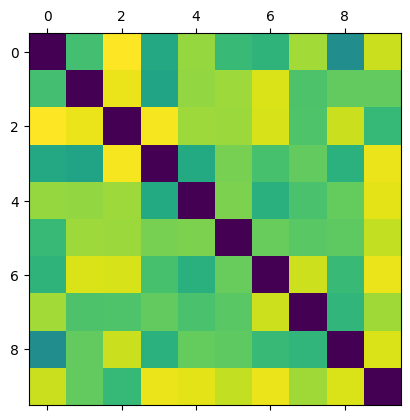

In [74]:
plt.matshow(distances, cmap="viridis")

In [75]:
visualization_df = pd.DataFrame(distances)
print(visualization_df)

          0         1         2         3         4         5         6  \
0  0.000000  0.799578  1.137250  0.686370  0.958865  0.770044  0.741263   
1  0.799578  0.000000  1.102473  0.664714  0.954157  0.972792  1.070814   
2  1.137250  1.102473  0.000000  1.122630  0.972007  0.965654  1.068629   
3  0.686370  0.664714  1.122630  0.000000  0.696629  0.905793  0.805516   
4  0.958865  0.954157  0.972007  0.696629  0.000000  0.914935  0.723627   
5  0.770044  0.972792  0.965654  0.905793  0.914935  0.000000  0.874833   
6  0.741263  1.070814  1.068629  0.805516  0.723627  0.874833  0.000000   
7  0.981259  0.817535  0.823175  0.862474  0.811918  0.847982  1.050589   
8  0.556960  0.863557  1.048281  0.724305  0.866686  0.856197  0.765171   
9  1.044476  0.865319  0.762497  1.104206  1.090827  1.034983  1.103667   

          7         8         9  
0  0.981259  0.556960  1.044476  
1  0.817535  0.863557  0.865319  
2  0.823175  1.048281  0.762497  
3  0.862474  0.724305  1.104206  
4  0

## Visualize Nearest Neighbors
Let's look at the trained embedding and visualize the nearest neighbors for
a few random samples.

We create some helper functions to simplify the work



In [76]:
def get_image_as_np_array(filename: str) -> np.ndarray:
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)

In [77]:
def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6) -> None:
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get num_examples random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()

        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            plt.imshow(get_image_as_np_array(fname))
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")

In [78]:
# plot_knn_examples(embeddings, filenames, n_neighbors=10, num_examples=10)

In [80]:
plot_knn_examples(embeddings, filenames, n_neighbors=7, num_examples=10)

In [ ]:
# plot_knn_examples(embeddings, filenames)

## Visualize Clusters on 2D Plane
Let's look at the trained embedding, perform PCA and visualize clusters in 2D space.

In [81]:
def plot_clusters(
    embeddings: np.ndarray = None,
    original_labels: np.ndarray = None,
    n_clusters: int = 10,
    proportion_of_points_to_plot: float = 0.001,
    alpha: float = 0.1,
) -> None:
    """Plots multiple rows of random images with their cluster centroids"""

    print(f"Working on embeddings of shape {embeddings.shape}")

    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_embeddings)
    centroids = kmeans.cluster_centers_

    print(f"Cluster centroids:\n {centroids}")
    print(f"Cluster sizes: {np.bincount(labels)}")

    # Sample proportion_of_points_to_plot of the data to plot for readability
    sampled_indices = np.random.choice(
        reduced_embeddings.shape[0],
        int(len(reduced_embeddings) * proportion_of_points_to_plot),
        replace=False,
    )
    sampled_embeddings = reduced_embeddings[sampled_indices]

    # this doesn't really make sense - you can see clusters with 'new' labels anyway
    # sampled_labels = labels[sampled_indices]
    sampled_labels = original_labels[sampled_indices]

    print(f"Plotting {len(sampled_embeddings)} points out of {len(reduced_embeddings)}")

    # plt.scatter(sampled_embeddings[:, 0], sampled_embeddings[:, 1], c=dataset_test.dataset.targets, alpha=0.1)
    plt.scatter(
        sampled_embeddings[:, 0], sampled_embeddings[:, 1], c=sampled_labels, alpha=alpha, cmap="magma"
    )
    plt.colorbar(label="Original Class Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Cluster Plot")
    plt.show()

In [82]:
# dataset_test.__dir__()
# dataset_test.dataset.__dir__()

# dataset_test.dataset.targets

# FIXME: dlaczego są same zera? (albo nie)

In [83]:
print(type(dataset_test.dataset.targets))
unique_targets = np.unique(dataset_test.dataset.targets)
print(unique_targets)
print(dataset_test.dataset.targets[0])
print(type(dataset_test.dataset.targets[0]))

<class 'list'>
[0]
0
<class 'int'>


Working on embeddings of shape (10000, 512)
Cluster centroids:
 [[-0.3127744   0.10123194]
 [ 0.55629375  0.19634469]
 [-0.20838556 -0.39825644]
 [ 0.56619491 -0.18119016]
 [-0.34238407 -0.17956305]
 [-0.21265634  0.3948271 ]
 [ 0.04283299 -0.13659497]
 [ 0.11618088  0.5168663 ]
 [ 0.21266951 -0.41150422]
 [ 0.11912924  0.17244881]]
Cluster sizes: [1251  665 1135 1044 1380 1205  925  953  784  658]
Plotting 100 points out of 10000


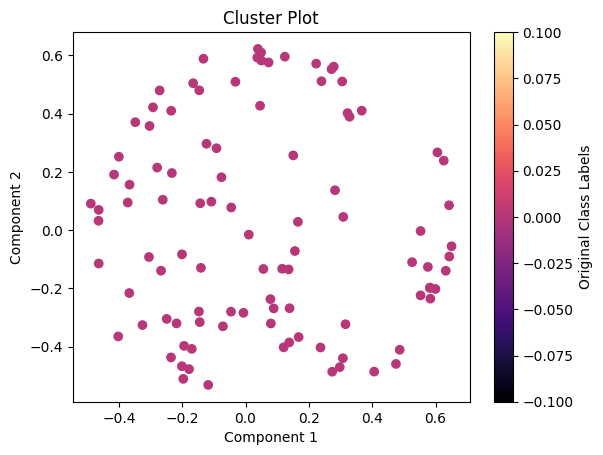

In [84]:
plot_clusters(embeddings, np.array(dataset_test.dataset.targets), proportion_of_points_to_plot=0.01, alpha=1)

## Check Labels Correspoding to Clusters
Let's check if the clusters in the embedding space correspond to the labels of the images.

In [ ]:
def check_labels_correspondence(
    embeddings: np.ndarray = None, n_clusters: int = 10, num_examples: int = 7
) -> None:

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(embeddings)
    unique_labels = set(labels)
    print(f"Unique labels: {unique_labels}")

    for label in unique_labels:
        # print(f"Label {label} has {np.sum(labels == label)} samples")
        label_indices = np.where(labels == label)[0]
        sampled_indices = np.random.choice(
            label_indices, size=num_examples, replace=False
        )
        # print(f"Length of sampled_indices: {len(sampled_indices)}")
        # print(f"Sampled indices: {sampled_indices}")

        fig = plt.figure()

        for subplot_idx, idx in enumerate(sampled_indices):
            ax = fig.add_subplot(len(unique_labels), num_examples, subplot_idx + 1)
            fname = os.path.join(path_to_data, filenames[idx])
            plt.imshow(get_image_as_np_array(fname))
            ax.set_title(f"Label {label}")
            plt.axis("off")

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


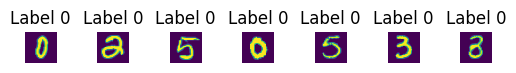

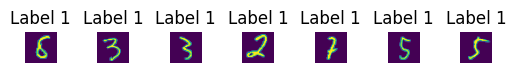

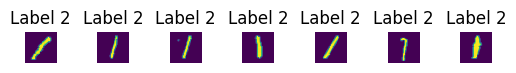

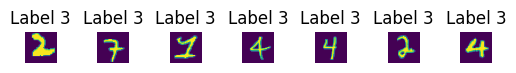

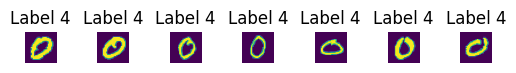

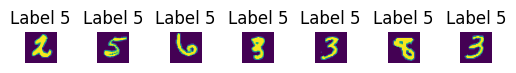

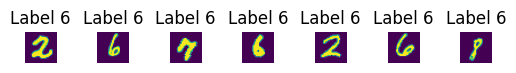

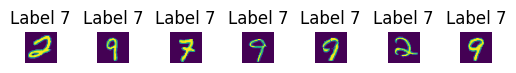

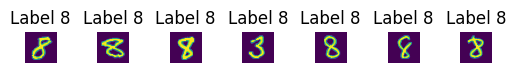

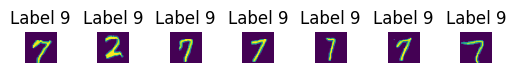

In [ ]:
check_labels_correspondence(embeddings)